In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,3)})

In [3]:
import seaborn as sns
sns.set(style='whitegrid')

In [4]:
import bambi as bmb, pandas as pd, numpy as np, arviz as az, pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [5]:
def make_ds(gid, x):
    return  pd.DataFrame({
        'gid': np.repeat(gid,len(x)),
        'x':np.hstack([x for _ in gid])
        #'gid_eps': np.repeat(gid+gid_eps,len(x)),

    })

In [6]:
np.random.seed(42)


x = np.linspace(-50,50,100)

df_meta = pd.Series(
    dict(
        y_sigma = 6,
        gid_slope_mu    = 2,
        gid_slope_sigma = 4,
        
    )
)

gid = np.array(['TX','CA','VA','NM'])

gid_slope = df_meta.gid_slope_mu + df_meta.gid_slope_sigma*np.random.randn(len(gid))
gid_slope

array([3.98685661, 1.4469428 , 4.59075415, 8.09211943])

In [7]:
df_meta['gid_slope_mu_sampled']= np.mean(gid_slope)
df_meta['gid_slope_sig_sampled']= np.std(gid_slope)
df_meta

y_sigma                  6.000000
gid_slope_mu             2.000000
gid_slope_sigma          4.000000
gid_slope_mu_sampled     4.529168
gid_slope_sig_sampled    2.371320
dtype: float64

,gid,x,gid_m,y
395,NM,45.959596,8.092119,379.337437
396,NM,46.969697,8.092119,370.517831
397,NM,47.979798,8.092119,384.662005
398,NM,48.989899,8.092119,396.463575
399,NM,50.000000,8.092119,404.887855


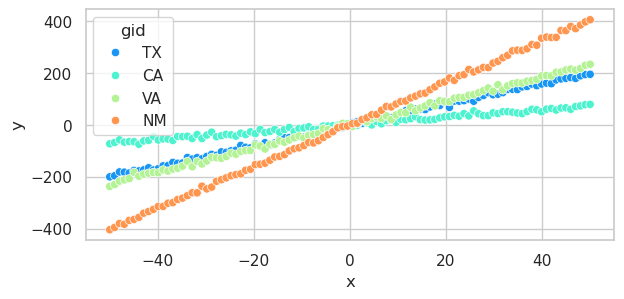

In [8]:
df_raw = (
    make_ds(gid, x)
    .assign(
        
        gid_m = np.repeat(gid_slope,len(x)),
        
        y = lambda df: df.x.mul(df.gid_m)+ (df_meta.y_sigma*np.random.randn(len(df.x)))
    )
)
sns.scatterplot(x='x',y='y',data=df_raw,hue='gid',palette='rainbow',ax=plt.subplot(121))
df_raw.tail()

In [9]:
df_raw.groupby('gid')['gid_m'].unique()

gid
CA    [1.4469427953152614]
NM     [8.092119425632102]
TX    [3.9868566120449307]
VA      [4.59075415240277]
Name: gid_m, dtype: object

In [10]:
df_raw.to_csv('df_raw.csv')

In [11]:
%load_ext rpy2.ipython

In [12]:

%%R
library(lme4)
library(lmerTest)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



# OLS

In [13]:
%%R

df_loaded = read.csv('df_raw.csv')
lm(y ~ 1+ x, df_loaded) -> m 
m |> summary()



Call:
lm(formula = y ~ 1 + x, data = df_loaded)

Residuals:
     Min       1Q   Median       3Q      Max 
-178.490  -22.076   -0.021   18.597  178.516 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.06523    3.47016   0.019    0.985    
x            4.52612    0.11901  38.030   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 69.4 on 398 degrees of freedom
Multiple R-squared:  0.7842,	Adjusted R-squared:  0.7837 
F-statistic:  1446 on 1 and 398 DF,  p-value: < 2.2e-16



In [14]:
ans_1=smf.ols('y~x',data=df_raw).fit()
print(ans_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1446.
Date:                Thu, 29 Feb 2024   Prob (F-statistic):          1.35e-134
Time:                        01:01:58   Log-Likelihood:                -2262.5
No. Observations:                 400   AIC:                             4529.
Df Residuals:                     398   BIC:                             4537.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0652      3.470      0.019      0.9

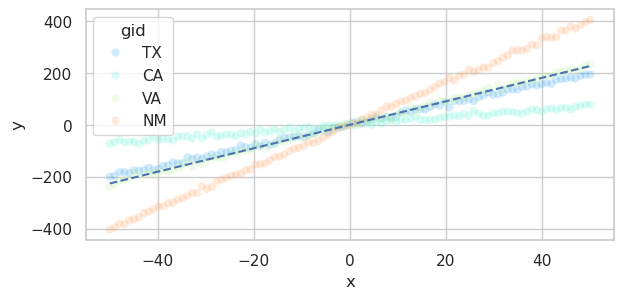

In [15]:
ax=plt.subplot(121)
sns.scatterplot(x='x',y='y',data=df_raw,hue='gid',palette='rainbow',ax=ax,alpha=0.2)

x_test = np.linspace(-50,50,1000)
y_pred = ans_1.predict(pd.DataFrame({'x':x_test}))
plt.plot(x_test,y_pred,ls='--')

In [16]:
%%R
lm(y ~ 0 + x*factor(gid), df_loaded) -> m 
m |> summary()



Call:
lm(formula = y ~ 0 + x * factor(gid), data = df_loaded)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.5625  -4.0827  -0.0029   3.5092  22.4448 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
x                1.44695    0.01981  73.057   <2e-16 ***
factor(gid)CA    0.49601    0.57749   0.859   0.3909    
factor(gid)NM    0.51444    0.57749   0.891   0.3736    
factor(gid)TX   -0.95369    0.57749  -1.651   0.0994 .  
factor(gid)VA    0.20416    0.57749   0.354   0.7239    
x:factor(gid)NM  6.63305    0.02801 236.814   <2e-16 ***
x:factor(gid)TX  2.55025    0.02801  91.049   <2e-16 ***
x:factor(gid)VA  3.13341    0.02801 111.869   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.775 on 392 degrees of freedom
Multiple R-squared:  0.9985,	Adjusted R-squared:  0.9985 
F-statistic: 3.325e+04 on 8 and 392 DF,  p-value: < 2.2e-16



In [17]:
ans_2=smf.ols('y~ 0+x*C(gid)',data=df_raw).fit()
print(ans_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.800e+04
Date:                Thu, 29 Feb 2024   Prob (F-statistic):               0.00
Time:                        01:01:59   Log-Likelihood:                -1264.9
No. Observations:                 400   AIC:                             2546.
Df Residuals:                     392   BIC:                             2578.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
C(gid)[CA]         0.4960      0.577      0.

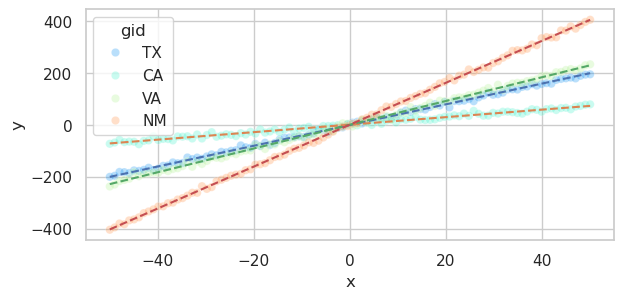

In [18]:
ax=plt.subplot(121)
sns.scatterplot(x='x',y='y',data=df_raw,hue='gid',palette='rainbow',ax=ax,alpha=0.3)

for g in gid:
    x_test = np.linspace(-50,50,1000)
    ds_test = make_ds([g],x_test)

    y_pred = ans_2.predict(ds_test)
    plt.plot(ds_test.x,y_pred,ls='--')

# Mixed Effect

In [19]:
%%R

lmer(y ~ 0 + x + (0 + x|gid), df_loaded) -> m 
m |> summary()


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: y ~ 0 + x + (0 + x | gid)
   Data: df_loaded

REML criterion at convergence: 2574.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3505 -0.7081  0.0268  0.6381  3.9201 

Random effects:
 Groups   Name Variance Std.Dev.
 gid      x     7.464   2.732   
 Residual      33.382   5.778   
Number of obs: 400, groups:  gid, 4

Fixed effects:
  Estimate Std. Error    df t value Pr(>|t|)  
x    4.526      1.366 3.000   3.313   0.0453 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [20]:
ans_3=smf.mixedlm(
    'y~ 0 + x', groups='gid', re_formula='~0+x',
    data=df_raw, 
).fit()
print(ans_3.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 400     Method:             REML      
No. Groups:       4       Scale:              33.3816   
Min. group size:  100     Log-Likelihood:     -1287.1516
Max. group size:  100     Converged:          Yes       
Mean group size:  100.0                                 
----------------------------------------------------------
        Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------
x       4.526      1.366   3.313   0.001    1.848    7.204
x Var   7.467      1.060                                  



In [21]:
ref_mixedlm = (
    pd.DataFrame(ans_3.random_effects).T
    .rename(columns={'x':'x|gid'})
    .assign(
        x_shared = ans_3.params['x'] ,
        total = lambda df: df.sum(axis=1),
        ground_truth = pd.Series(gid_slope,index = gid)
    )     
)
ref_mixedlm

,x|gid,x_shared,total,ground_truth
CA,-3.079016,4.526124,1.447108,1.446943
NM,3.553683,4.526124,8.079807,8.092119
TX,-0.528897,4.526124,3.997227,3.986857
VA,0.054229,4.526124,4.580353,4.590754


# PyMC

In [22]:
df_meta

y_sigma                  6.000000
gid_slope_mu             2.000000
gid_slope_sigma          4.000000
gid_slope_mu_sampled     4.529168
gid_slope_sig_sampled    2.371320
dtype: float64

In [23]:
idx = pd.Categorical(df_raw['gid'])

with pm.Model(coords={'gid':idx.categories, 'idx_g':idx.codes}) as model:
        
    hyper_mu = pm.Normal('hyper_mu', mu=0, sigma=5) 
    hyper_sig =pm.HalfStudentT('hyper_sig', nu=5,sigma=5)   
    #hyper_sig = pm.Exponential('hyper_sig', lam=5)     
    
    mu_xg = pm.Normal('mu_x|g', mu=hyper_mu, sigma=hyper_sig, dims='gid')            
           
    y_sigma = pm.HalfStudentT('y_sigma', nu=5,sigma=5)
    #y_sigma = pm.Exponential('y_sigma', lam=5)     
    
    y_hat = mu_xg[idx.codes]*df_raw.x 
    
    y = pm.Normal('y', mu=y_hat, sigma=y_sigma, observed=df_raw.y)
    
        

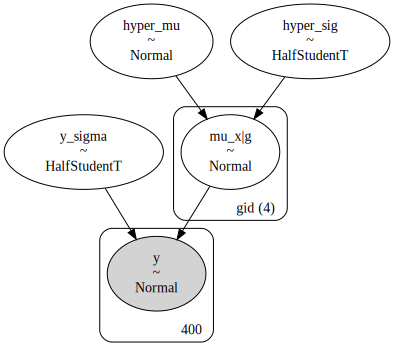

In [24]:
pm.model_to_graphviz(model)

In [25]:
with model:
    prior_trace = pm.sample_prior_predictive(4000)

Sampling: [hyper_mu, hyper_sig, mu_x|g, y, y_sigma]


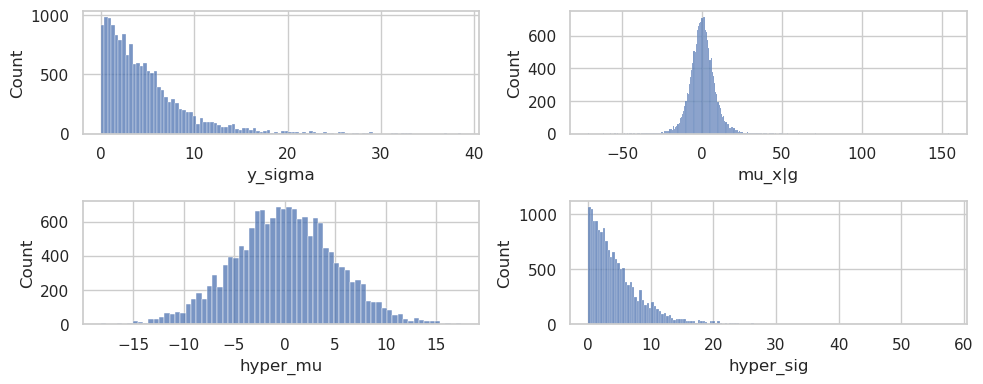

In [26]:
plt.figure(figsize=(10,4))
df_prior = prior_trace.prior.to_dataframe()
for cnt, key in enumerate(df_prior.columns,1):
    sns.histplot(df_prior[key],ax=plt.subplot(2,2,cnt))#.set(title=key)
plt.tight_layout()    

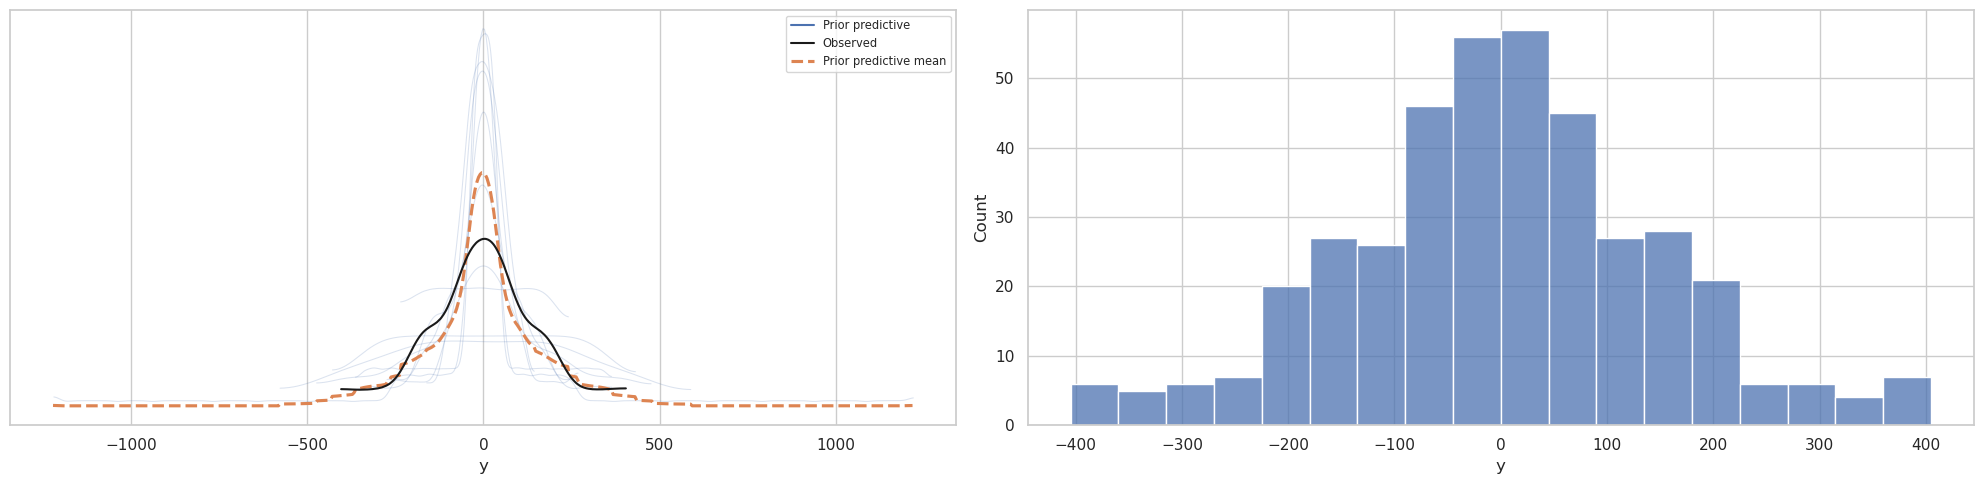

In [27]:
plt.figure(figsize=(20,5))
az.plot_ppc(prior_trace, num_pp_samples=10,group='prior',ax=plt.subplot(121))
sns.histplot(df_raw.y,ax=plt.subplot(122))
plt.tight_layout()

In [28]:
with model:
    trace = pm.sample(4000, tune=1000) #
    pm.sample_posterior_predictive(trace,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hyper_mu, hyper_sig, mu_x|g, y_sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 17 seconds.
Sampling: [y]


In [29]:
ref_mixedlm 

,x|gid,x_shared,total,ground_truth
CA,-3.079016,4.526124,1.447108,1.446943
NM,3.553683,4.526124,8.079807,8.092119
TX,-0.528897,4.526124,3.997227,3.986857
VA,0.054229,4.526124,4.580353,4.590754


In [30]:
az.summary(trace, kind='stats',var_names=['mu_x|g'])

,mean,sd,hdi_3%,hdi_97%
mu_x|g[CA],1.447,0.02,1.411,1.487
mu_x|g[NM],8.080,0.02,8.043,8.117
mu_x|g[TX],3.997,0.02,3.961,4.035
mu_x|g[VA],4.581,0.02,4.544,4.619


In [31]:
df_meta

y_sigma                  6.000000
gid_slope_mu             2.000000
gid_slope_sigma          4.000000
gid_slope_mu_sampled     4.529168
gid_slope_sig_sampled    2.371320
dtype: float64

In [32]:
az.summary(trace, kind='stats',var_names=['~mu_x|g'])

,mean,sd,hdi_3%,hdi_97%
hyper_mu,3.962,1.843,0.215,7.308
hyper_sig,3.706,1.755,1.372,6.823
y_sigma,5.789,0.206,5.415,6.183


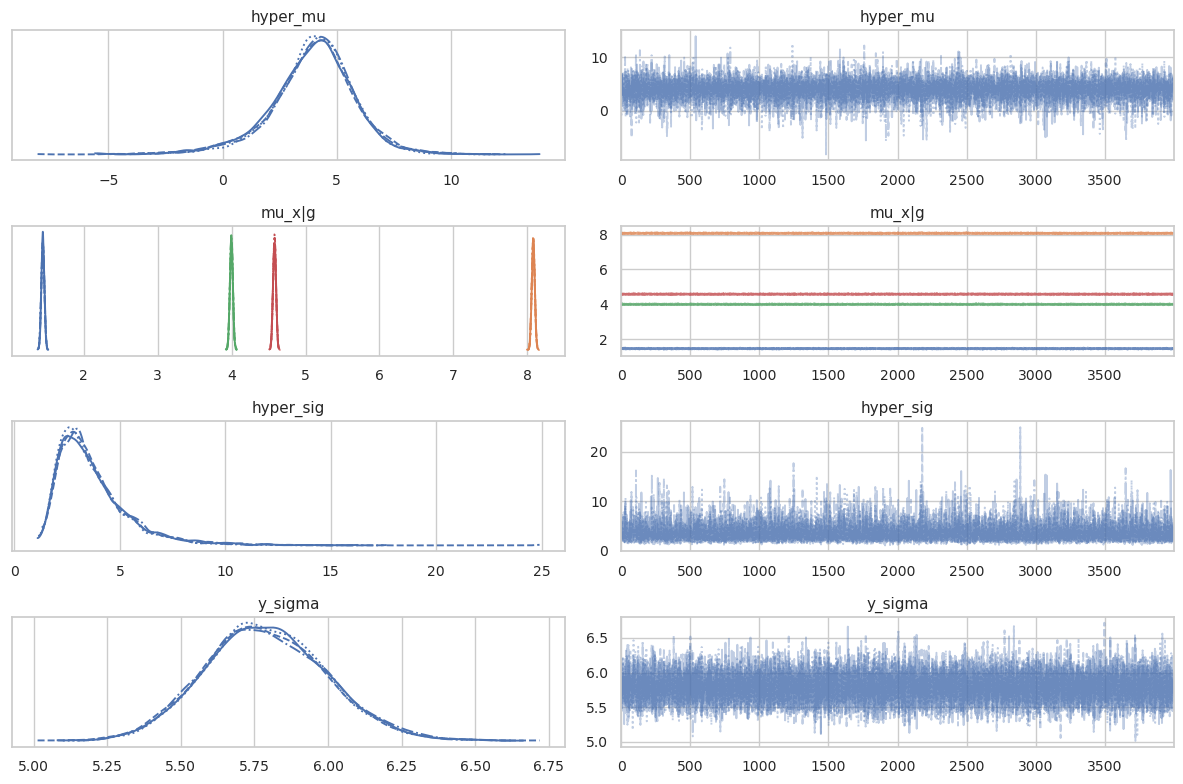

In [33]:
az.plot_trace(trace); plt.tight_layout()

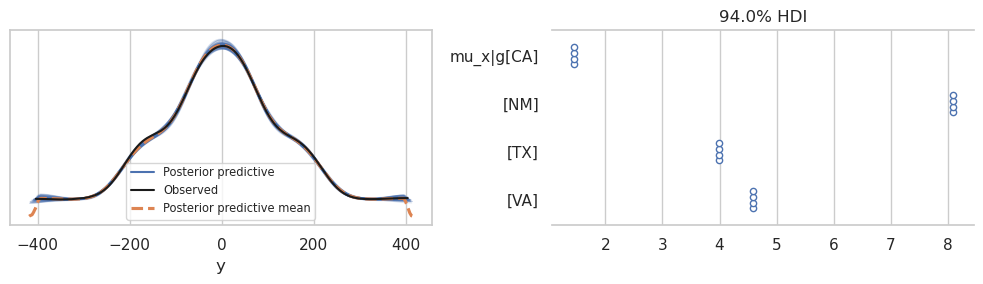

In [34]:
plt.figure(figsize=(10,3))
az.plot_ppc(trace, num_pp_samples=100,ax=plt.subplot(121))
az.plot_forest(trace, var_names=['mu_x|g'],figsize=(10,3),ax=plt.subplot(122))
plt.tight_layout()

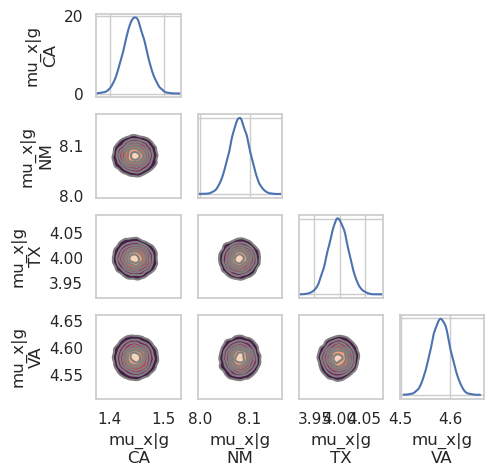

In [35]:
az.plot_pair(trace, var_names=['mu_x|g'],figsize=(5,5),kind='kde',marginals=True);

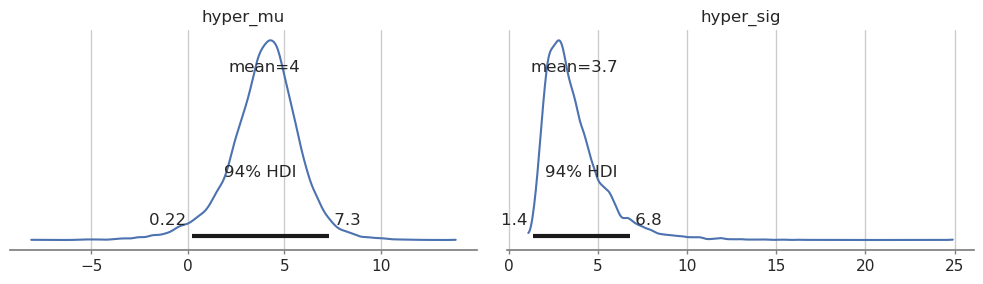

In [36]:
az.plot_posterior(trace,var_names=['hyper_mu','hyper_sig'],figsize=(10,3));
plt.tight_layout()

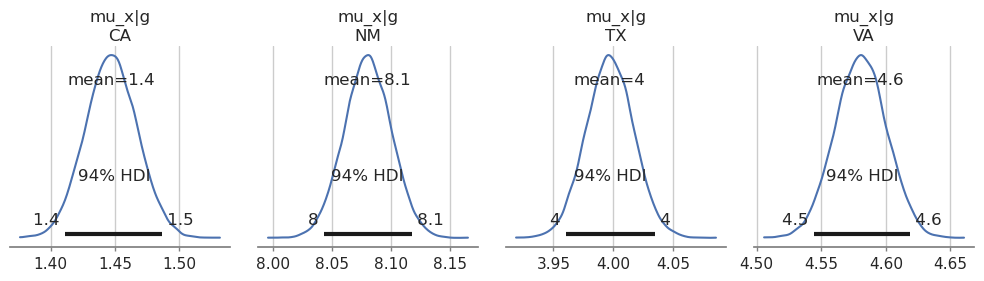

In [37]:
az.plot_posterior(trace,var_names=['mu_x|g'],figsize=(10,3));
plt.tight_layout()

# BmB

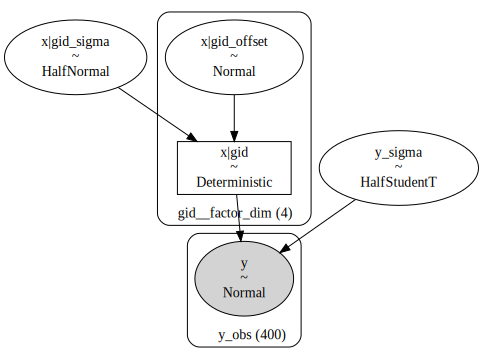

In [38]:
mdl1 = bmb.Model('y~ 0 + (0+x|gid)', data=df_raw)
mdl1.build(); mdl1.graph()

In [39]:
mdl1

       Formula: y~ 0 + (0+x|gid)
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Group-level effects
            x|gid ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 12.7777))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 149.0272)

In [40]:
res1 = mdl1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x|gid_sigma, x|gid_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.


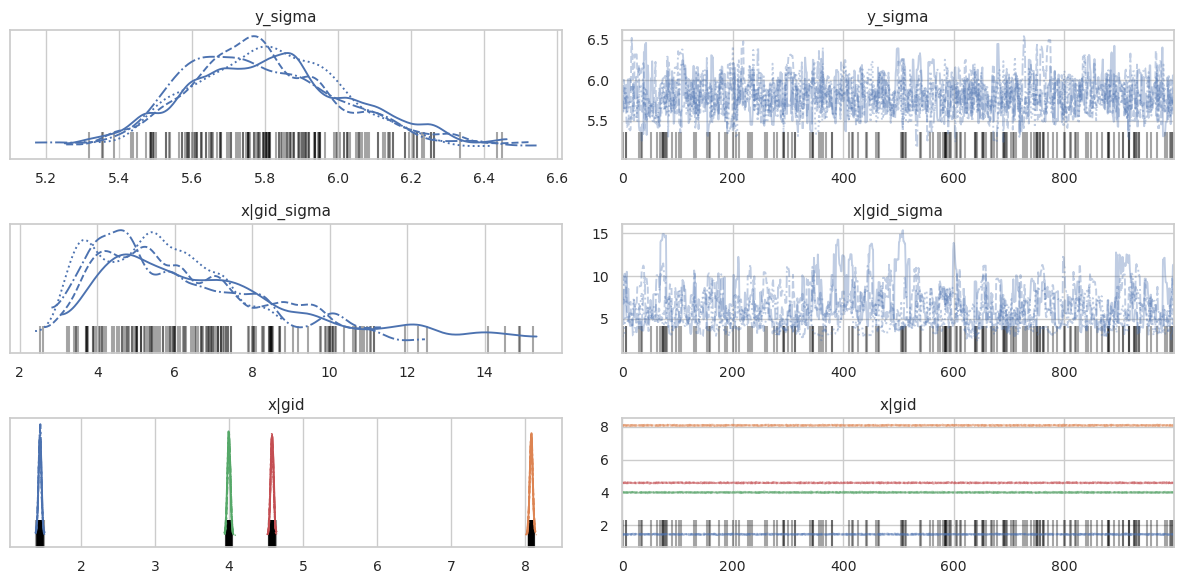

In [41]:
az.plot_trace(res1); plt.tight_layout()

In [42]:
az.summary(res1,kind='stats')

,mean,sd,hdi_3%,hdi_97%
y_sigma,5.804,0.217,5.446,6.256
x|gid_sigma,6.132,2.172,2.989,10.150
x|gid[CA],1.446,0.020,1.408,1.483
x|gid[NM],8.080,0.020,8.043,8.118
x|gid[TX],3.998,0.020,3.960,4.033
x|gid[VA],4.580,0.020,4.542,4.614


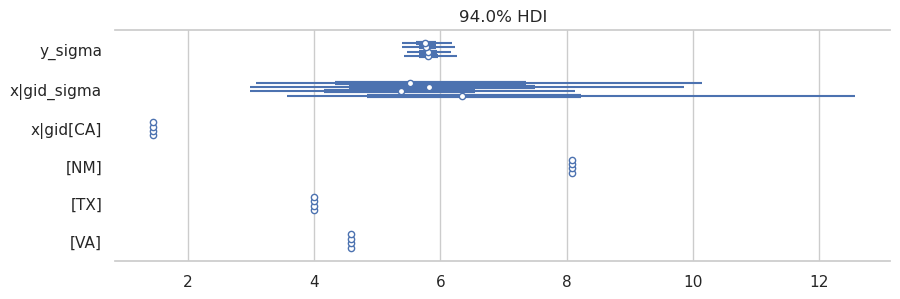

In [43]:
az.plot_forest(res1,figsize=(10,3));